# Carlos Mazuecos Reíllo 202106145

# Lab: XAI and Uncertainty for Time-Series Forecasting (Panama Load)

You are data scientists at a grid operator in Panama. Your task is short-term load forecasting, interpreting model behaviour (XAI), and estimating predictive uncertainty so operators can make safer operational decisions. This notebook walks you through EDA, feature engineering, training a model, SHAP explanations, temporal attribution with occlusion, bootstrap-based variability, and conformal prediction intervals.

Follow the TODO markers in code cells. The dataset is expected at `data/panama_load.csv` and should contain at least a timestamp column and a load column. Optional covariates (temperature, humidity, etc.) are welcome.

In [1]:
# Section 0 - Setup
# Imports, plotting style, and random seed
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.graphics.tsaplots import plot_acf
import shap
import warnings
warnings.filterwarnings('ignore')

# Plot style and seed
sns.set_style('whitegrid')
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

c:\Users\carlo\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Section 1 — Load data and basic EDA

Goal: understand the time series, inspect seasonality, and spot anomalies. Follow instructions and fill TODOs.

You can learn more about the dataset at: https://www.kaggle.com/datasets/saurabhshahane/electricity-load-forecasting

In [2]:
# 1) Load data into a DataFrame
path = '../data/panama_load.csv'
if not os.path.exists(path):
    print(f'WARNING: {path} not found. Please place the dataset at this path.')
df = pd.read_csv(path)
print(f'Data loaded with shape: {df.shape}')

Data loaded with shape: (48048, 17)


In [3]:
datetime_col = 'datetime' 
load_col = 'nat_demand'  
# Attempt to parse a datetime column robustly
if datetime_col not in df.columns:
    # try to guess a datetime-like column
    for c in df.columns:
        if 'date' in c.lower() or 'time' in c.lower():
            datetime_col = c
            break
print('Using datetime column:', datetime_col)
# Parse datetimes
try:
    df[datetime_col] = pd.to_datetime(df[datetime_col])
except Exception as e:
    print('Error parsing datetimes:', e)
# Set index and sort
df = df.set_index(datetime_col).sort_index()

print('Using load column:', load_col)
# Keep a clean dataframe with at least datetime index and load
data = df[[load_col]].copy()
data.columns = ['load']
data = data.sort_index()
data.head()

Using datetime column: datetime
Using load column: nat_demand


,load
datetime,
2015-01-03 01:00:00,970.3450
2015-01-03 02:00:00,912.1755
2015-01-03 03:00:00,900.2688
2015-01-03 04:00:00,889.9538
2015-01-03 05:00:00,893.6865


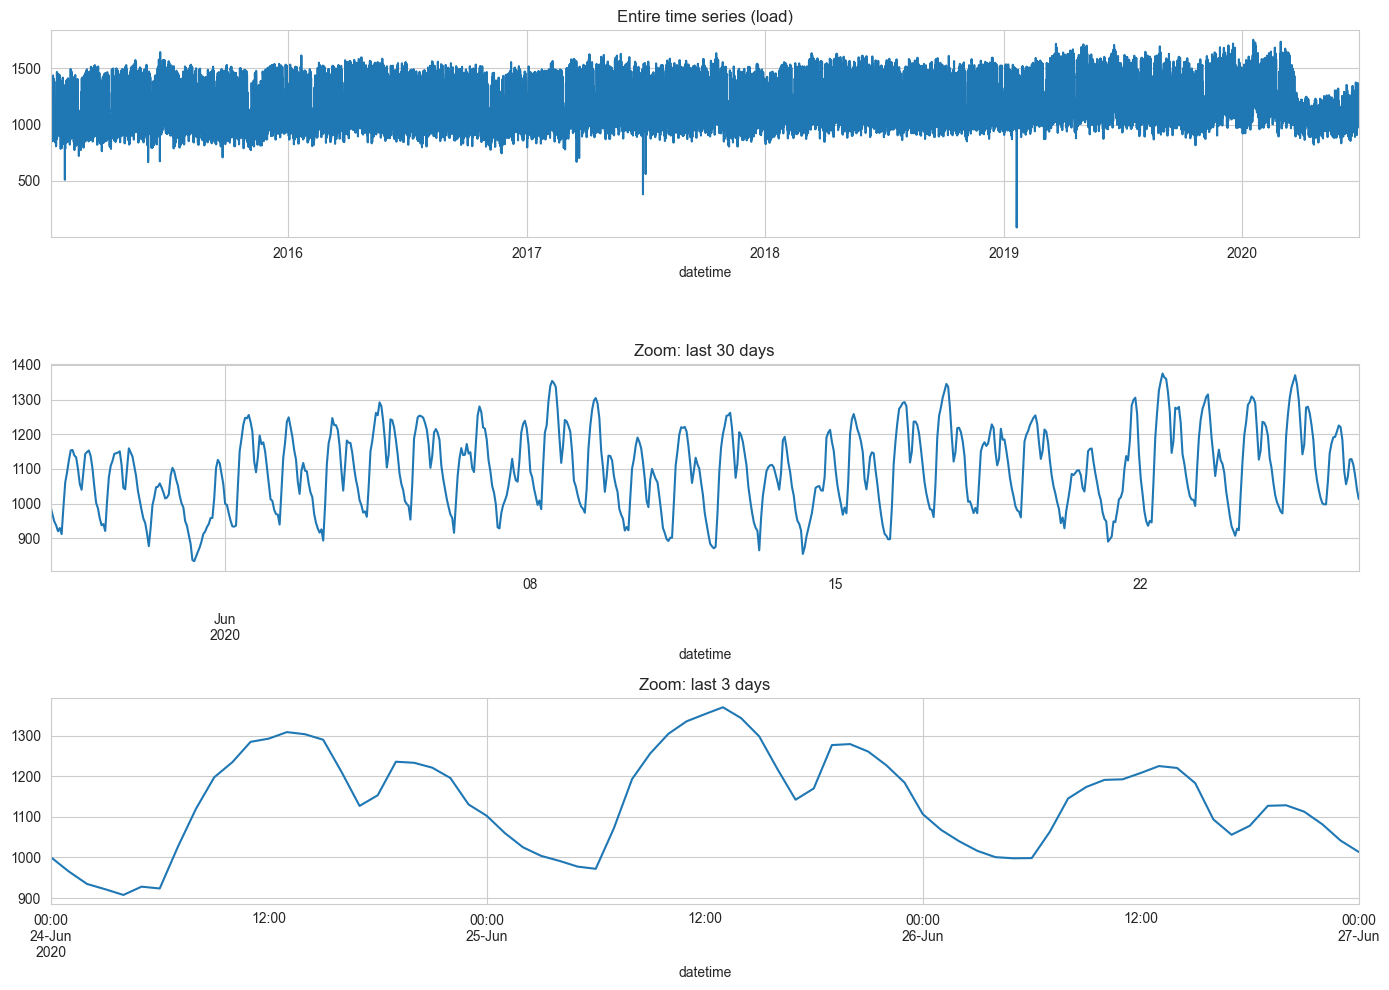

In [4]:
# 2) Basic plots: entire series, one month, a couple of days
fig, ax = plt.subplots(3, 1, figsize=(14, 10), sharex=False)
# Entire series
data['load'].plot(ax=ax[0], title='Entire time series (load)')
# Zoom into one month (choose the last available month)
last = data.index.max()
month_start = (last - pd.Timedelta(days=30)).ceil('D')
data.loc[month_start:last, 'load'].plot(ax=ax[1], title='Zoom: last 30 days')
# Zoom into a couple of days
days_start = (last - pd.Timedelta(days=3)).ceil('D')
data.loc[days_start:last, 'load'].plot(ax=ax[2], title='Zoom: last 3 days')
plt.tight_layout()
plt.show()

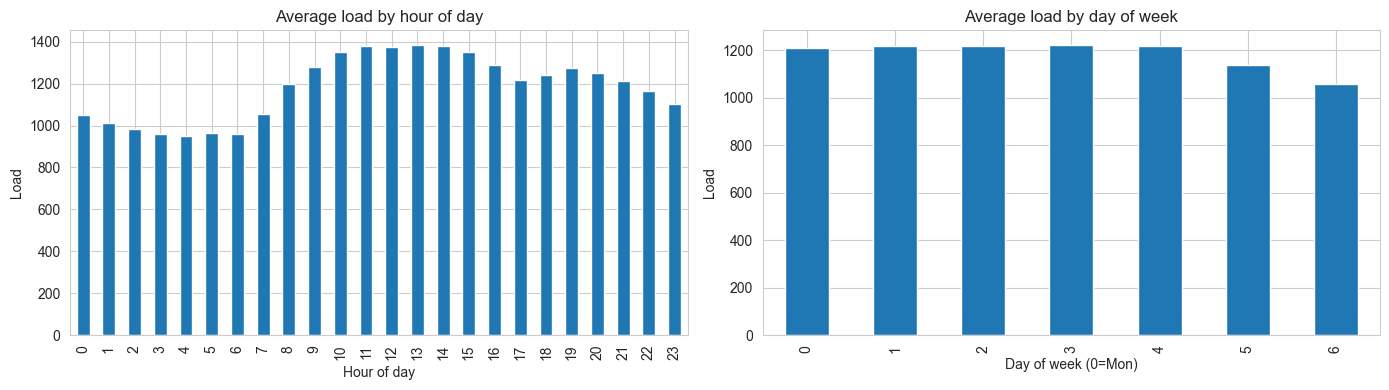

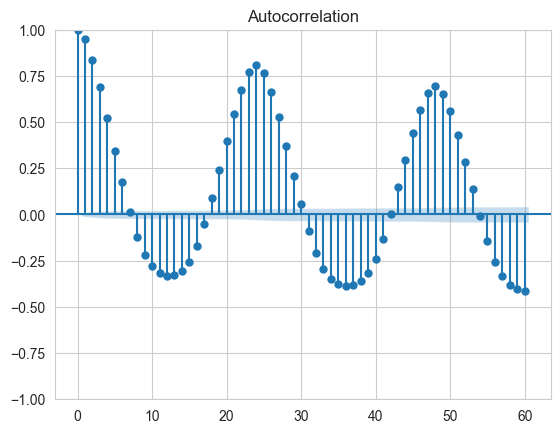

In [5]:
# 3) Average load by hour-of-day and day-of-week
df_feats = data.copy()
df_feats['hour'] = df_feats.index.hour
df_feats['dow'] = df_feats.index.dayofweek
hourly = df_feats.groupby('hour')['load'].mean()
dow = df_feats.groupby('dow')['load'].mean()
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 4))
hourly.plot(kind='bar', ax=ax1, title='Average load by hour of day')
ax1.set_xlabel('Hour of day')
ax1.set_ylabel('Load')
dow.plot(kind='bar', ax=ax2, title='Average load by day of week')
ax2.set_xlabel('Day of week (0=Mon)')
ax2.set_ylabel('Load')
plt.tight_layout()
plot_acf(data['load'].dropna(), lags=60)
plt.show()


- TODO: Inspect the previous plots and comment on the patterns you can distinguish

>>> 
On the first graphs we can see that the load through all the days was always between 900 and 1500 except for a few outliers (they seem to be isolated issues with measurement). We can also appreciate how on march 2020 (covid begins), the load values now go from 900 to 1200, reflecting a drop in energy consumption during COVID.

When looking to the daily graphs we can analyze that there is a pattern and that during the day, the load increases with the sunrise until 11 where it remains at its maximum until 14, then it slightly decreases until 17, where it increases little until 19 and finally it decreases until the next sunrise. This confirms the hourly seasonality typical of electricity demand.

The load during the week is very similar every day and slightly higher than on Saturdays, which is also higher than Sundays. This weekly seasonality suggests behavioral differences in energy use between workdays and weekends.

Finally, the ACF plot shows strong correlations at short lags, meaning the load is highly related to its recent past. We also see clear peaks around 24 and 48 hours, which reflect the daily seasonality of the demand.

## Section 2 — Turn time series into supervised learning data

We convert the time series into a tabular supervised problem: predict 1-step-ahead load from lag features, rolling statistics and calendar features.
Fill TODOs in the helper function below.

In [6]:
def make_supervised(df, target_col='load', horizon=1, lags=None):
    """Create supervised features for a 1-step-ahead forecast."""
    if lags is None:
        lags = [1, 24, 48, 168]  # t-1, t-24 (daily), t-48, t-168 (weekly)
        # lags = [1, 168]
    X = pd.DataFrame(index=df.index)
    # Lag features
    for lag in lags:
        X[f'lag_{lag}'] = df[target_col].shift(lag)
    # Rolling features: 24-hour and 7-day rolling mean/std
    X['rmean_24'] = df[target_col].rolling(window=24, min_periods=1).mean().shift(1)
    X['rstd_24'] = df[target_col].rolling(window=24, min_periods=1).std().shift(1)
    X['rmean_168'] = df[target_col].rolling(window=168, min_periods=1).mean().shift(1)
    # Calendar features
    X['hour'] = df.index.hour
    X['dow'] = df.index.dayofweek
    X['is_weekend'] = (X['dow'] >= 5).astype(int)
    X['month'] = df.index.month
    # Target (1-step ahead by default)
    y = df[target_col].shift(-horizon)
    # Align and drop NaNs caused by shifts
    X = X.loc[~y.isna()]
    y = y.loc[X.index]
    return X, y
# Build supervised data
X, y = make_supervised(data, target_col='load', horizon=1)
print('X shape:', X.shape, 'y shape:', y.shape)
# show a few rows
X.head()

X shape: (48047, 11) y shape: (48047,)


,lag_1,lag_24,lag_48,lag_168,rmean_24,rstd_24,rmean_168,hour,dow,is_weekend,month
datetime,,,,,,,,,,,
2015-01-03 01:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,5,1,1
2015-01-03 02:00:00,970.3450,NaN,NaN,NaN,970.345000,NaN,970.345000,2,5,1,1
2015-01-03 03:00:00,912.1755,NaN,NaN,NaN,941.260250,41.132048,941.260250,3,5,1,1
2015-01-03 04:00:00,900.2688,NaN,NaN,NaN,927.596433,37.496964,927.596433,4,5,1,1
2015-01-03 05:00:00,889.9538,NaN,NaN,NaN,918.185775,35.938700,918.185775,5,5,1,1


## Section 3 — Time-based train / calibration / test split

Random splits leak future information in time series. We'll split chronologically: TRAIN (first 60%), CALIBRATION (next 20%), TEST (last 20%). The calibration set will be used for conformal prediction intervals.


In [7]:
# Chronological split
n = len(X)
i_train = int(n * 0.6)
i_cal = int(n * 0.8)
X_train = X.iloc[:i_train]
y_train = y.iloc[:i_train]
X_cal = X.iloc[i_train:i_cal]
y_cal = y.iloc[i_train:i_cal]
X_test = X.iloc[i_cal:]
y_test = y.iloc[i_cal:]
print('TRAIN range:', X_train.index.min(), 'to', X_train.index.max(), 'size', len(X_train))
print('CAL range:', X_cal.index.min(), 'to', X_cal.index.max(), 'size', len(X_cal))
print('TEST range:', X_test.index.min(), 'to', X_test.index.max(), 'size', len(X_test))

TRAIN range: 2015-01-03 01:00:00 to 2018-04-18 04:00:00 size 28828
CAL range: 2018-04-18 05:00:00 to 2019-05-23 13:00:00 size 9609
TEST range: 2019-05-23 14:00:00 to 2020-06-26 23:00:00 size 9610


## Section 4 — Baseline model and ML model

We compare a naive baseline (previous value) to a trained tree-based regressor. Evaluate using MAE and RMSE.


Naive baseline MAE: 78.688, RMSE: 100.701
RandomForest MAE: 35.885, RMSE: 54.490


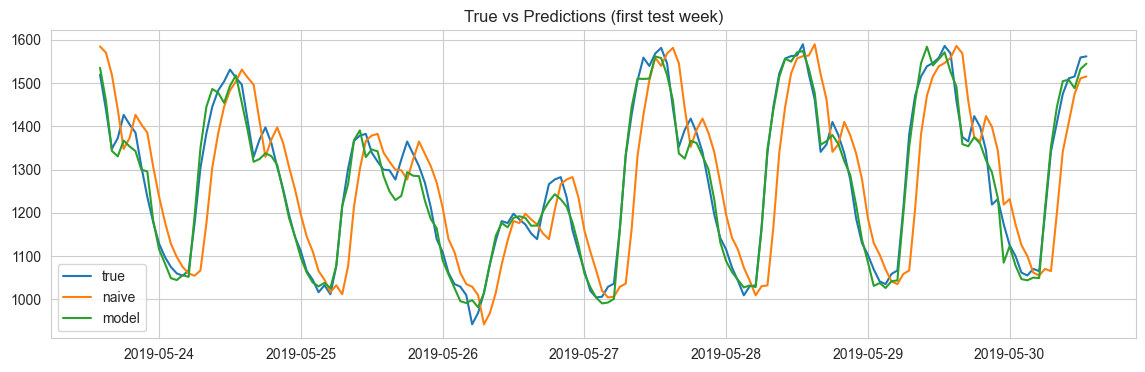

In [8]:
# Naive baseline: predict using lag_1 (t-1). Align carefully.
y_test_index = y_test.index
# Baseline predictions: because target is t, naive is previous observed load at t-1 which is lag_1 feature
yhat_naive = X_test['lag_1']
# Fit a RandomForest as example ML model (students can replace with XGBoost/LGBM)
model = RandomForestRegressor(n_estimators=100, random_state=RANDOM_SEED, n_jobs=-1)

# TODO: fit the model on (X_train, y_train)
model.fit(X_train, y_train)
# Predict on test
yhat = pd.Series(model.predict(X_test), index=X_test.index)
# Evaluation
def evaluate(y_true, y_pred, label='model'):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = mean_squared_error(y_true, y_pred)**0.5
    print(f'{label} MAE: {mae:.3f}, RMSE: {rmse:.3f}')

evaluate(y_test, yhat_naive, label='Naive baseline')
evaluate(y_test, yhat, label='RandomForest')
# Plot a selected TEST week: choose first week of test set
try:
    plot_start = X_test.index[0]
    plot_end = plot_start + pd.Timedelta(days=7)
    idx = (y_test.index >= plot_start) & (y_test.index < plot_end)
    plt.figure(figsize=(14, 4))
    plt.plot(y_test.loc[idx].index, y_test.loc[idx].values, label='true')
    plt.plot(yhat_naive.loc[idx].index, yhat_naive.loc[idx].values, label='naive')
    plt.plot(yhat.loc[idx].index, yhat.loc[idx].values, label='model')
    plt.legend()
    plt.title('True vs Predictions (first test week)')
    plt.show()
except Exception as e:
    print('Could not plot test week:', e)

## Section 5 — Global and local XAI with SHAP

We use SHAP to explain feature importance globally and locally. For tree models, TreeExplainer is efficient. For other models, KernelExplainer may be used but is slower.


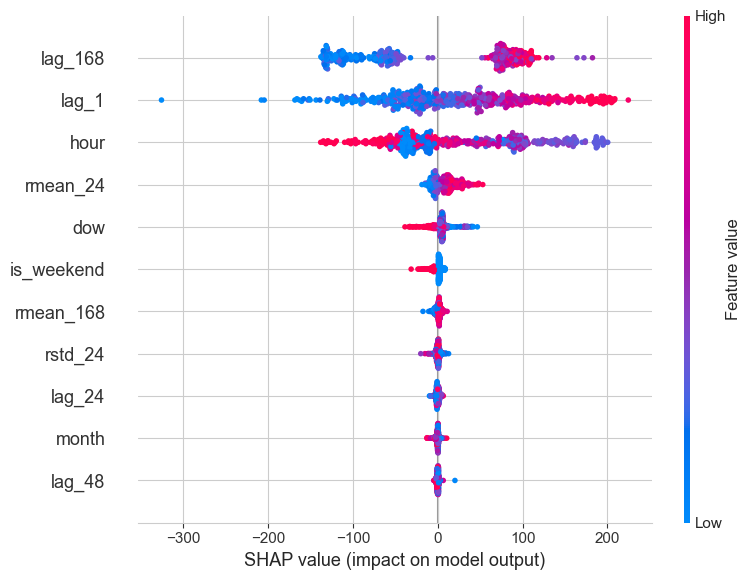

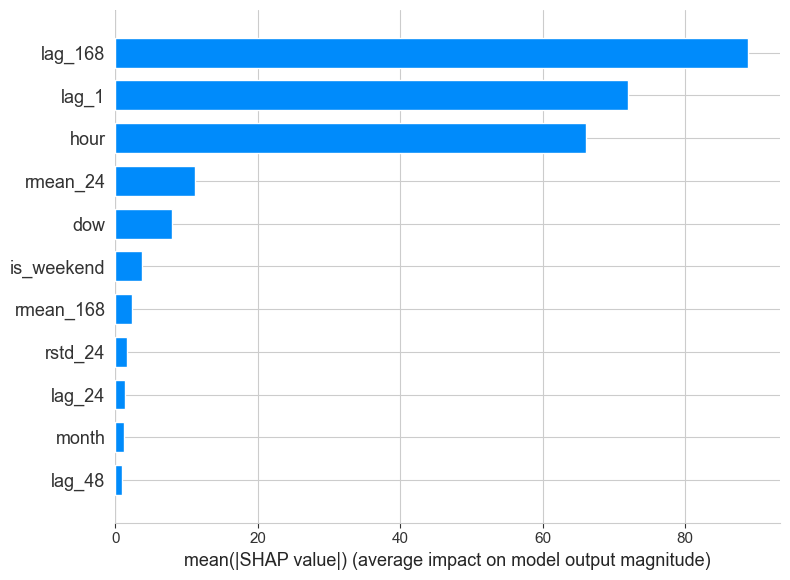

Index with highest load in test: 2020-01-17 13:00:00
Could not produce local SHAP waterfall: The waterfall plot requires an `Explanation` object as the `shap_values` argument.


In [9]:
# Select a subset of X_test for SHAP analysis (to keep compute small)
X_shap = X_test.sample(n=min(500, len(X_test)), random_state=RANDOM_SEED)
# Use TreeExplainer for tree-based models
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_shap)
# Summary plot (beeswarm)
shap.summary_plot(shap_values, X_shap, show=True)
# Bar plot of mean absolute SHAP values
shap.summary_plot(shap_values, X_shap, plot_type='bar', show=True)
# Local explanation for a single interesting point (e.g., highest true load in test)
idx_max = y_test.idxmax()
print('Index with highest load in test:', idx_max)
x_local = X_test.loc[[idx_max]]
try:
    sv_local = explainer.shap_values(x_local)
    shap.plots.waterfall(sv_local[0] if isinstance(sv_local, list) else sv_local, max_display=12)
except Exception as e:
    print('Could not produce local SHAP waterfall:', e)

- TODO: Interpret SHAP results, are there any innecessary inputs? Try to simplify the model and check performance variations. Does SHAP results match domain intuition?
>>> 

The 168 lag is one of the most important variables for predicting the model. 168 hours is a period of one week, which makes sense. It is also important to notice that the 1 lag is also an important variable. In both cases it is appreciated that a high lag value (red dots) increases the prediction while a low value (blue dots) reduces it.

In addition, the hour is also important altough its ontribution is not as clear as the lags as we can see that there are blue and red points with positive and negativa impact both. The rest of the inputs are not as important. In this case some inputs as lag_48, month, lag_24 show very small SHAP magnitudes and could be considered unnecessary inputs for the model.

Changing the n_estimators doesn't affect dramtically the SHAP values. By repeating the analysis with simpler models (20 and 5 estimators), the SHAP remains the practically identitical which means that simplifying the model does not alter the behavior. MAE and RMSE are the same even if n_estimators is changed.

The results are consistent with the intuition about energy demand. The same hour from previous week and the previous hour of the current day are the best predictors of the current load.





## Section 6 — Bootstrap ensemble for predictive variability

Train B bootstrap models (resampling training data with replacement) to approximate variability due to training data sampling. Use their distribution to produce prediction intervals.


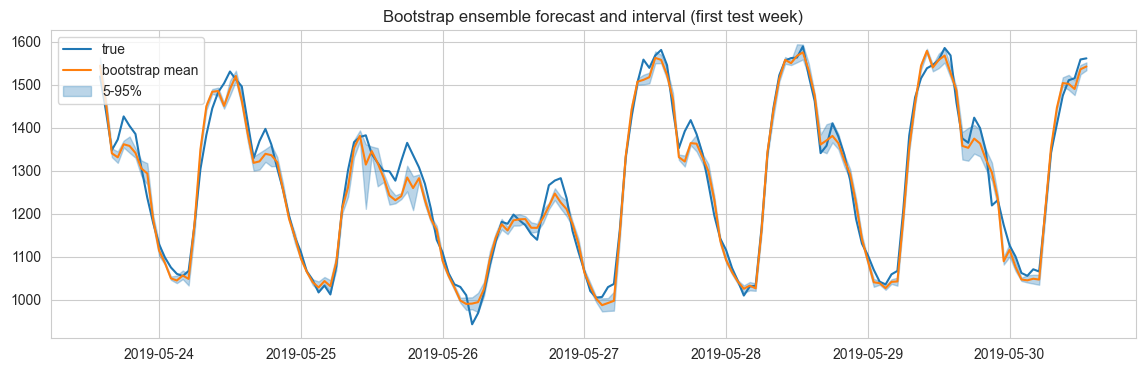

In [10]:
from copy import deepcopy
def bootstrap_models(X_train, y_train, base_model, B=10):
    models = []
    n = len(X_train)
    for b in range(B):
        idx = np.random.choice(np.arange(n), size=n, replace=True)
        Xb = X_train.iloc[idx]
        yb = y_train.iloc[idx]
        m = deepcopy(base_model)
        m.fit(Xb, yb)
        models.append(m)
    return models
# Train B bootstrap models (may take time)
B = 10
base = RandomForestRegressor(n_estimators=100, random_state=RANDOM_SEED)

# TODO: If running time is a concern reduce B or model complexity
models_b = bootstrap_models(X_train, y_train, base, B=B)
# Compute bootstrap predictions for X_test (may be memory heavy; sample a week for plotting)
def bootstrap_predict(models, X):
    preds = np.vstack([m.predict(X) for m in models])  # shape (B, n)
    return preds
preds_b = bootstrap_predict(models_b, X_test)
# Mean and 5th-95th percentile interval
y_mean = preds_b.mean(axis=0)
y_p05 = np.percentile(preds_b, 5, axis=0)
y_p95 = np.percentile(preds_b, 95, axis=0)
# Plot a test week with bootstrap interval
try:
    plot_start = X_test.index[0]
    plot_end = plot_start + pd.Timedelta(days=7)
    mask = (X_test.index >= plot_start) & (X_test.index < plot_end)
    plt.figure(figsize=(14, 4))
    plt.plot(y_test.loc[mask].index, y_test.loc[mask].values, label='true')
    plt.plot(X_test.loc[mask].index, y_mean[mask], label='bootstrap mean')
    plt.fill_between(X_test.loc[mask].index, y_p05[mask], y_p95[mask], color='C0', alpha=0.3, label='5-95%')
    plt.legend()
    plt.title('Bootstrap ensemble forecast and interval (first test week)')
    plt.show()
except Exception as e:
    print('Could not plot bootstrap week:', e)

## Section 7 — Conformal prediction intervals (inductive residual-based)

Inductive conformal uses residuals on a held-out calibration set to form a distribution of absolute errors; the quantile gives a symmetric interval around point predictions with finite-sample marginal coverage guarantees (under exchangeability).

Conformal q (alpha=0.1): 45.749855000000025
Coverage on TEST (alpha=0.1): 0.747, avg width: 91.500
   alpha          q  coverage   avg_width
0   0.05  61.489332  0.842664  122.978664
1   0.10  45.749855  0.747242   91.499710
2   0.20  32.138579  0.619667   64.277158


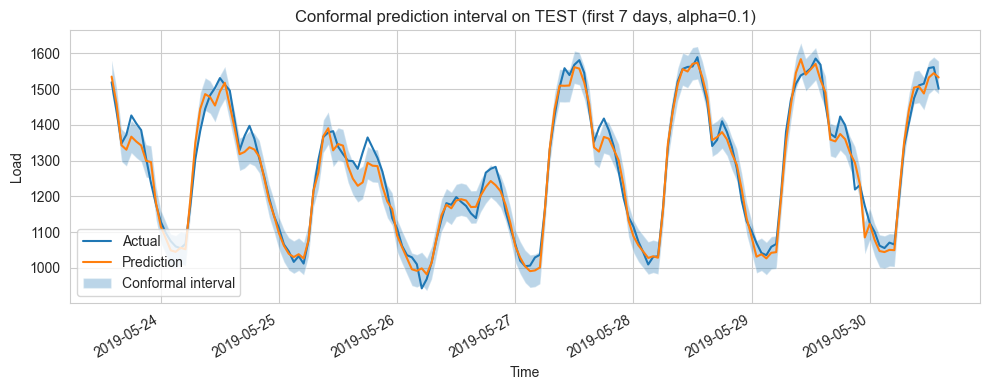

In [11]:
# --- Conformal quantile from calibration residuals ---

# Train a fresh model on TRAIN if desired. We'll reuse `model` already trained, but you can retrain here.
# model.fit(X_train, y_train)

# Predict on calibration set and compute residuals
yhat_cal = pd.Series(model.predict(X_cal), index=X_cal.index)
residuals = (y_cal - yhat_cal).abs()

def conformal_q(residuals, alpha=0.1):
    """
    Compute conformal quantile with finite-sample correction:
    quantile at ceil((n+1)*(1-alpha))/n.
    """
    n = len(residuals)
    k = int(np.ceil((n + 1) * (1 - alpha))) - 1
    q = np.sort(residuals)[k]
    return q

alpha = 0.1
q_alpha = conformal_q(residuals.values, alpha=alpha)
print(f'Conformal q (alpha={alpha}):', q_alpha)

# --- Build intervals on TEST ---

yhat_test = pd.Series(model.predict(X_test), index=X_test.index)
lower = yhat_test - q_alpha
upper = yhat_test + q_alpha

# Evaluate empirical coverage and average width
inside = ((y_test >= lower) & (y_test <= upper)).mean()
avg_width = (upper - lower).mean()
print(f'Coverage on TEST (alpha={alpha}): {inside:.3f}, avg width: {avg_width:.3f}')

# Optionally loop over several alphas
alphas = [0.05, 0.1, 0.2]
rows = []
for a in alphas:
    q = conformal_q(residuals.values, alpha=a)
    yhat_test_a = pd.Series(model.predict(X_test), index=X_test.index)
    l = yhat_test_a - q
    u = yhat_test_a + q
    cov = ((y_test >= l) & (y_test <= u)).mean()
    rows.append({'alpha': a, 'q': q, 'coverage': cov, 'avg_width': (u - l).mean()})

conformal_summary = pd.DataFrame(rows)
print(conformal_summary)

# --- Plot conformal predictions along the time series (first 7 days of TEST) ---

import matplotlib.pyplot as plt

# Define plot window: first 7 days of the test period
plot_start = X_test.index[0]
plot_end = plot_start + pd.Timedelta(days=7)

mask = (y_test.index >= plot_start) & (y_test.index <= plot_end)

y_test_plot = y_test[mask]
yhat_plot = yhat_test[mask]
lower_plot = lower[mask]
upper_plot = upper[mask]

fig, ax = plt.subplots(figsize=(10, 4))

ax.plot(y_test_plot.index, y_test_plot, label='Actual')
ax.plot(yhat_plot.index, yhat_plot, label='Prediction')
ax.fill_between(yhat_plot.index, lower_plot, upper_plot, alpha=0.3, label='Conformal interval')

ax.set_title(f'Conformal prediction interval on TEST (first 7 days, alpha={alpha})')
ax.set_xlabel('Time')
ax.set_ylabel('Load')
ax.legend()
fig.autofmt_xdate()

plt.tight_layout()
plt.show()


- TODO: Comment on the results, which you find more useful: bootstrap or conformal? Which would you use in case I ask you about uncertainty in forecasting models?
>>> 

I find conformal more useful because you can easily change the alpha value and control how strict you want the interval to be. The intervals are usually wider but more informative, and comparing different alphas is very useful. Bootstrap, on the other hand, tends to produce intervals that are too narrow and doesn’t offer a clear way to tune the level of uncertainty wanted.

Conformal also adapts better to forecasting settings, where model errors are not always stable and where having guaranteed coverage is a real advantage.

If I had to talk about uncertainty in forecasting, I would choose conformal, since it makes it much easier to decide how much uncertainty you want to allow and provides intervaals that are more reliable in practice.

## Section 9 — Using intervals for anomaly flagging

Flag times where true load lies outside conformal intervals — potentially anomalous events requiring operator attention.


Number of anomalies in TEST: 2429


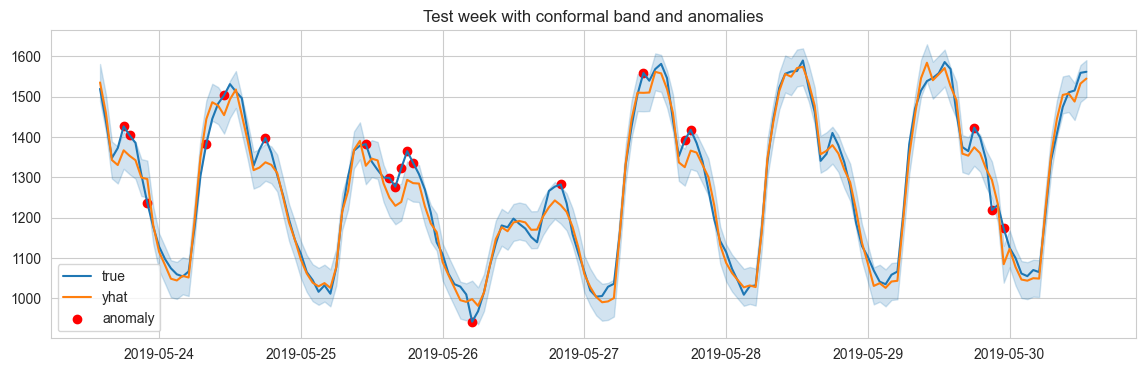

,y_true,yhat,lower,upper,anomaly
datetime,,,,,
2019-05-23 18:00:00,1426.328300,1366.956192,1321.206337,1412.706047,True
2019-05-23 19:00:00,1404.167525,1353.413410,1307.663555,1399.163265,True
2019-05-23 22:00:00,1236.931400,1295.806039,1250.056184,1341.555894,True
2019-05-24 08:00:00,1383.298800,1444.640992,1398.891137,1490.390847,True
2019-05-24 11:00:00,1503.377200,1454.076919,1408.327064,1499.826774,True
2019-05-24 18:00:00,1397.329200,1337.344336,1291.594481,1383.094191,True
2019-05-25 11:00:00,1382.318000,1328.694119,1282.944264,1374.443974,True
2019-05-25 15:00:00,1298.430500,1249.570631,1203.820776,1295.320486,True
2019-05-25 16:00:00,1276.796600,1229.535050,1183.785195,1275.284905,True


In [12]:
# Using alpha chosen earlier
yhat_test = pd.Series(model.predict(X_test), index=X_test.index)
lower = yhat_test - q_alpha
upper = yhat_test + q_alpha
anomaly = ~( (y_test >= lower) & (y_test <= upper) )
anomalies = pd.DataFrame({'y_true': y_test, 'yhat': yhat_test, 'lower': lower, 'upper': upper, 'anomaly': anomaly})
print('Number of anomalies in TEST:', anomalies['anomaly'].sum())
# Plot a test week with anomalies marked
try:
    mask = (X_test.index >= X_test.index[0]) & (X_test.index < X_test.index[0] + pd.Timedelta(days=7))
    plt.figure(figsize=(14, 4))
    plt.plot(anomalies.loc[mask].index, anomalies.loc[mask, 'y_true'], label='true')
    plt.plot(anomalies.loc[mask].index, anomalies.loc[mask, 'yhat'], label='yhat')
    plt.fill_between(anomalies.loc[mask].index, anomalies.loc[mask, 'lower'], anomalies.loc[mask, 'upper'], color='C0', alpha=0.2)
    # mark anomalies
    an_idx = anomalies.loc[mask & anomalies['anomaly']].index
    plt.scatter(an_idx, anomalies.loc[an_idx, 'y_true'], color='red', label='anomaly')
    plt.legend()
    plt.title('Test week with conformal band and anomalies')
    plt.show()
except Exception as e:
    print('Could not plot anomalies:', e)
# Print a small table of anomalies (timestamp, y_true, yhat, lower, upper)
anomalies[anomalies['anomaly']].head(20)

- TODO: Are the anomalies true grid events or model errors? Justify your answer
>>> 

Nearly all anomaly points occur around normal peaks of the daily load cycle, where the model typically struggles with sharp changes. Because the real load looks smooth and normal, these points are more likely model errors than real grid events. Some anomalies also appear during normal rises or drops, which means the model probably used intervals that were too narrow. So overall, the anomalies seem to come from prediction mistakes rather than actual grid problems.

## Section 10 — Visualizing

- How would you present these results to non-technical stakeholders at a grid operator? Include visuals and short bullet recommendations. Add as many code and markdown cells as you find necessary.


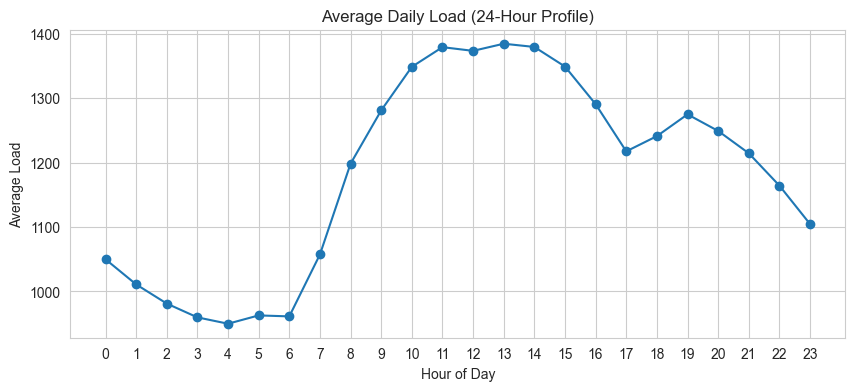

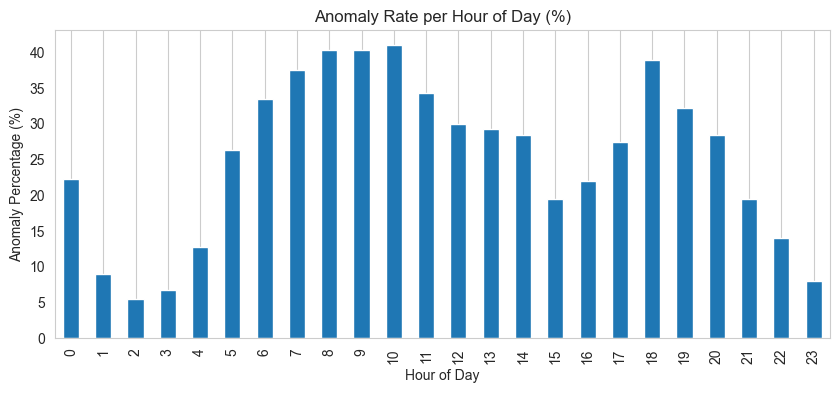

hour
0     22.250000
1      9.000000
2      5.500000
3      6.750000
4     12.750000
5     26.250000
6     33.500000
7     37.500000
8     40.250000
9     40.250000
10    41.000000
11    34.250000
12    30.000000
13    29.250000
14    28.428928
15    19.451372
16    21.945137
17    27.431421
18    38.902743
19    32.169576
20    28.428928
21    19.451372
22    13.965087
23     7.980050
Name: anomaly, dtype: float64

In [13]:
df_hourly_profile = data.copy()
df_hourly_profile["hour"] = df_hourly_profile.index.hour

avg_daily_profile = df_hourly_profile.groupby("hour")["load"].mean()

plt.figure(figsize=(10,4))
avg_daily_profile.plot(marker='o')
plt.title("Average Daily Load (24-Hour Profile)")
plt.xlabel("Hour of Day")
plt.ylabel("Average Load")
plt.grid(True)
plt.xticks(range(24))
plt.show()

anom = anomalies.copy()
anom["hour"] = anom.index.hour

anomaly_rate_hour = (
    anom.groupby("hour")["anomaly"]
        .mean() * 100   # percentage
)

plt.figure(figsize=(10,4))
anomaly_rate_hour.plot(kind="bar")
plt.title("Anomaly Rate per Hour of Day (%)")
plt.xlabel("Hour of Day")
plt.ylabel("Anomaly Percentage (%)")
plt.grid(axis='y')
plt.show()

anomaly_rate_hour


The anomaly rate is highest during hours with fast demand transitions, especially the morning (06–11) and the evening (17–20), where forecasting is more difficult.  
Night hours (1–4) show the lowest anomaly rates because demand is stable and predictable.  
Flat periods have moderate anomaly levels, reflecting easier modeling during steady load.  
Anomalies in genearal follow the load's volatility: rapid changes increase uncertainty, stable hours reduce it.


In [14]:
df_season = data.copy()
df_season["month"] = df_season.index.month

def manual_season(m):
    if m in [1, 2, 3]:
        return "Winter_JanMar"
    elif m in [4, 5, 6]:
        return "Spring_AprJun"
    elif m in [7, 8, 9]:
        return "Summer_JulSep"
    else:
        return "Autumn_OctDec"

df_season["season"] = df_season["month"].map(manual_season)
df_season["hour"] = df_season.index.hour


In [15]:
anom["month"] = anom.index.month
anom["season"] = anom["month"].map(manual_season)

anom


,y_true,yhat,lower,upper,anomaly,hour,month,season
datetime,,,,,,,,
2019-05-23 14:00:00,1519.251075,1535.035502,1489.285647,1580.785357,False,14,5,Spring_AprJun
2019-05-23 15:00:00,1438.600325,1459.026562,1413.276707,1504.776417,False,15,5,Spring_AprJun
2019-05-23 16:00:00,1347.792450,1343.045512,1297.295657,1388.795367,False,16,5,Spring_AprJun
2019-05-23 17:00:00,1372.608725,1330.521604,1284.771749,1376.271459,False,17,5,Spring_AprJun
2019-05-23 18:00:00,1426.328300,1366.956192,1321.206337,1412.706047,True,18,5,Spring_AprJun
...,...,...,...,...,...,...,...,...
2020-06-26 19:00:00,1128.559200,1127.957465,1082.207610,1173.707320,False,19,6,Spring_AprJun
2020-06-26 20:00:00,1112.748800,1069.898546,1024.148691,1115.648401,False,20,6,Spring_AprJun
2020-06-26 21:00:00,1081.568000,1063.299421,1017.549566,1109.049276,False,21,6,Spring_AprJun


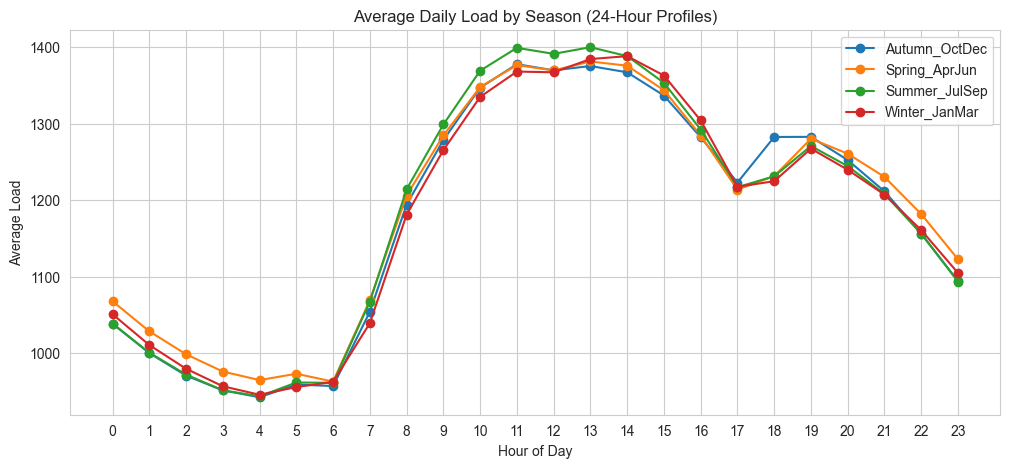

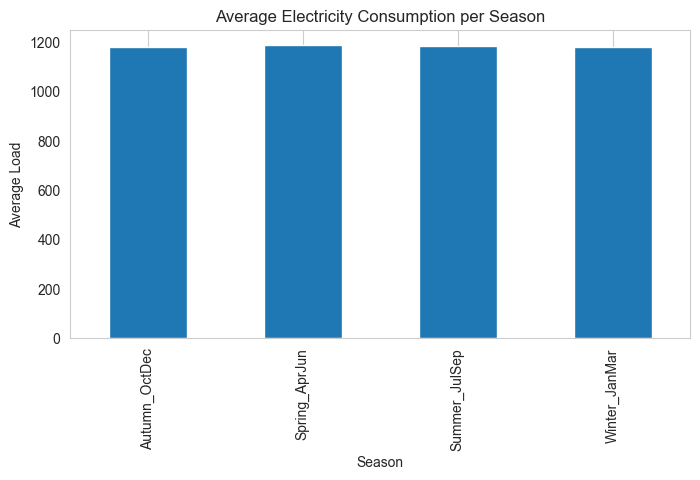

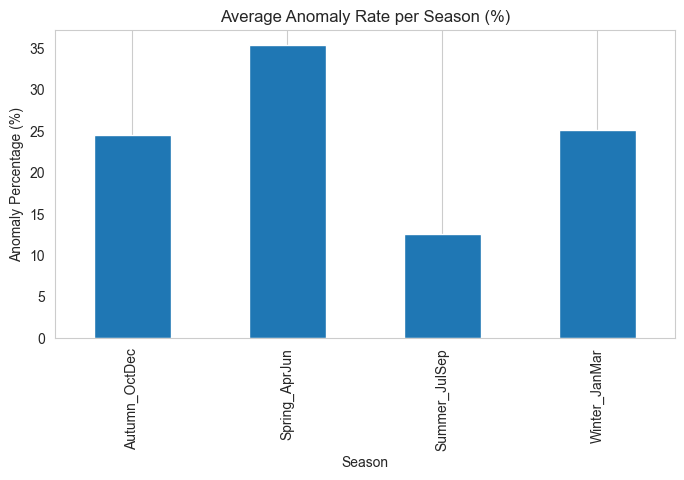

In [16]:
season_hourly = df_season.groupby(["season", "hour"])["load"].mean()
season_hourly = season_hourly.reset_index()
plt.figure(figsize=(12,5))
for s in sorted(season_hourly["season"].unique()):
    subset = season_hourly[season_hourly["season"] == s]
    plt.plot(subset["hour"], subset["load"], marker='o', label=s)

plt.title("Average Daily Load by Season (24-Hour Profiles)")
plt.xlabel("Hour of Day")
plt.ylabel("Average Load")
plt.xticks(range(24))
plt.grid(True)
plt.legend()
plt.show()



# Compute average load per season
avg_per_season = df_season.groupby("season")["load"].mean()

plt.figure(figsize=(8,4))
avg_per_season.sort_index().plot(kind="bar")
plt.title("Average Electricity Consumption per Season")
plt.xlabel("Season")
plt.ylabel("Average Load")
plt.grid(axis='y')
plt.show()



avg_anom_per_season = (
    anom.groupby("season")["anomaly"]
        .mean() * 100
).sort_index()



plt.figure(figsize=(8,4))
avg_anom_per_season.plot(kind="bar")
plt.title("Average Anomaly Rate per Season (%)")
plt.xlabel("Season")
plt.ylabel("Anomaly Percentage (%)")
plt.grid(axis='y')
plt.show()



Seasonal load levels are very similar across the year, with only small differences.  
In contrast, anomaly rates vary strongly: Spring shows the highest uncertainty, while Summer is the most stable.  


In [17]:
df_dow = data.copy()
df_dow["dow"] = df_dow.index.dayofweek
df_dow["hour"] = df_dow.index.hour

dow_hourly = df_dow.groupby(["dow", "hour"])["load"].mean()
dow_hourly = dow_hourly.reset_index()


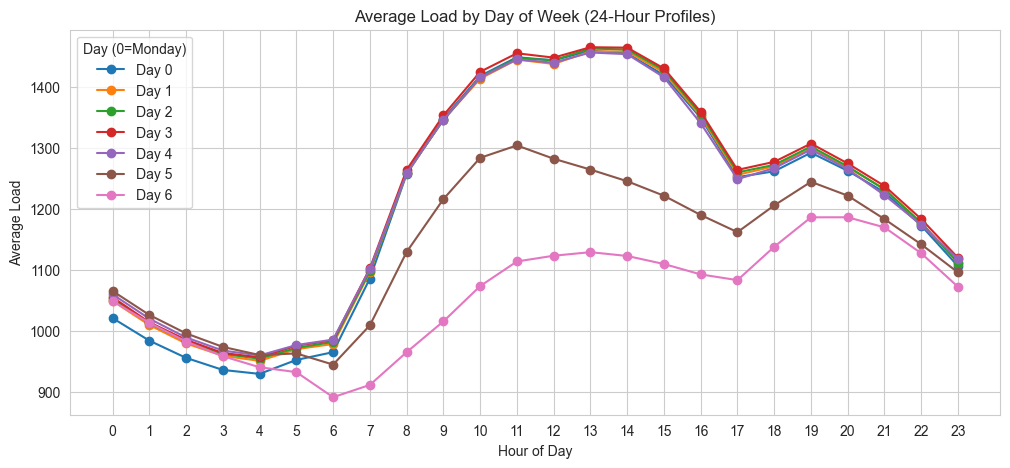

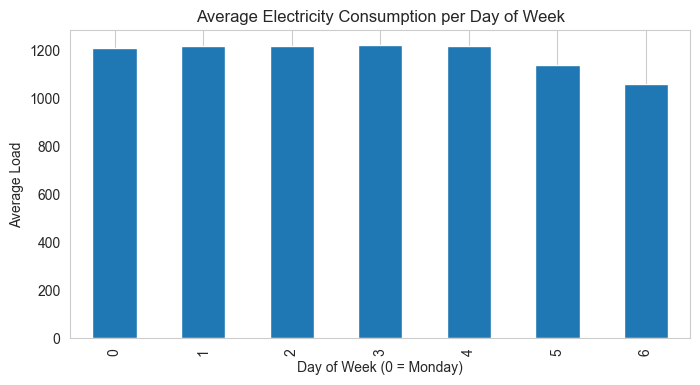

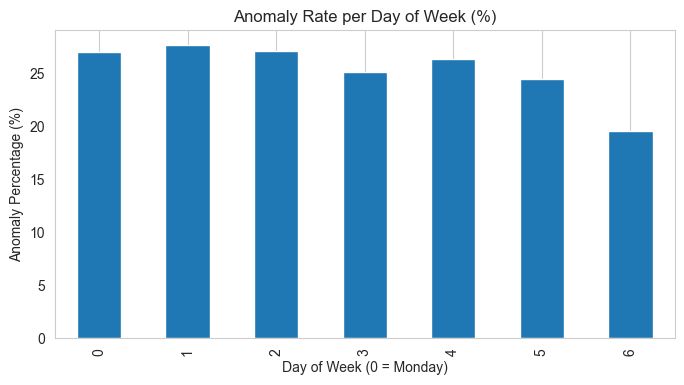

dow
0    26.973684
1    27.631579
2    27.046784
3    25.036284
4    26.293103
5    24.415205
6    19.517544
Name: anomaly, dtype: float64

In [18]:
plt.figure(figsize=(12,5))
for d in sorted(dow_hourly["dow"].unique()):
    subset = dow_hourly[dow_hourly["dow"] == d]
    plt.plot(subset["hour"], subset["load"], marker='o', label=f"Day {d}")

plt.title("Average Load by Day of Week (24-Hour Profiles)")
plt.xlabel("Hour of Day")
plt.ylabel("Average Load")
plt.xticks(range(24))
plt.grid(True)
plt.legend(title="Day (0=Monday)")
plt.show()





avg_per_dow = df_dow.groupby("dow")["load"].mean()

plt.figure(figsize=(8,4))
avg_per_dow.plot(kind="bar")
plt.title("Average Electricity Consumption per Day of Week")
plt.xlabel("Day of Week (0 = Monday)")
plt.ylabel("Average Load")
plt.grid(axis='y')
plt.show()





anom["dow"] = anom.index.dayofweek  # 0=Mon, 6=Sun

anomaly_rate_dow = (
    anom.groupby("dow")["anomaly"]
        .mean() * 100
)

plt.figure(figsize=(8,4))
anomaly_rate_dow.plot(kind="bar")
plt.title("Anomaly Rate per Day of Week (%)")
plt.xlabel("Day of Week (0 = Monday)")
plt.ylabel("Anomaly Percentage (%)")
plt.grid(axis='y')
plt.show()

anomaly_rate_dow





Average load is clearly higher on weekdays and drops on Saturday and especially Sunday.  
Anomaly rates follow the same pattern: they are highest Monday–Friday and lowest on Sunday.  
This suggests the model handles stable weekend demand better, while weekday variability introduces more uncertainty and anomalies.


## Conclusion 

The analysis shows that electricity demand follows clear daily, weekly, and seasonal patterns, with predictable peaks and stable load periods which are when it's low load.  
The forecasting model performs well during stable hours but becomes less reliable during rapid demand changes, such as mornings and evenings.  
Conformal prediction intervals provide a practical way to express uncertainty and highlight potential anomalies for operator attention.  
Most detected anomalies correspond to modeling difficulty rather than true grid issues, especially on weekdays and in Spring.  
